In [1]:
import yt
from yt import YTArray
from yt import YTQuantity

from astropy import constants as const

import numpy as np

import matplotlib
%matplotlib inline
import matplotlib.pylab as plt
from matplotlib.colors import SymLogNorm, LogNorm

import palettable
import plotting_tools as pt
import yt_functions as ytf


yt : [INFO     ] 2019-11-05 12:38:31,377 Parameters: current_time              = 0
yt : [INFO     ] 2019-11-05 12:38:31,378 Parameters: domain_dimensions         = [128 128 128]
yt : [INFO     ] 2019-11-05 12:38:31,379 Parameters: domain_left_edge          = [-2. -2. -2.]
yt : [INFO     ] 2019-11-05 12:38:31,380 Parameters: domain_right_edge         = [2. 2. 2.]
yt : [INFO     ] 2019-11-05 12:38:31,381 Parameters: cosmological_simulation   = 0.0


yt : [INFO     ] 2019-11-05 14:02:16,574 Parameters: current_time              = 0.099999019074139
yt : [INFO     ] 2019-11-05 14:02:16,575 Parameters: domain_dimensions         = [128 128 128]
yt : [INFO     ] 2019-11-05 14:02:16,576 Parameters: domain_left_edge          = [-2. -2. -2.]
yt : [INFO     ] 2019-11-05 14:02:16,577 Parameters: domain_right_edge         = [2. 2. 2.]
yt : [INFO     ] 2019-11-05 14:02:16,578 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2019-11-05 14:02:16,609 Gathering a field list (this may take a moment.)
yt : [INFO     ] 2019-11-05 14:02:17,806 xlim = -2.000000 2.000000
yt : [INFO     ] 2019-11-05 14:02:17,807 ylim = -2.000000 2.000000
yt : [INFO     ] 2019-11-05 14:02:17,809 xlim = -2.000000 2.000000
yt : [INFO     ] 2019-11-05 14:02:17,810 ylim = -2.000000 2.000000
yt : [INFO     ] 2019-11-05 14:02:17,813 Making a fixed resolution buffer of (('gas', 'density')) 800 by 800
yt : [INFO     ] 2019-11-05 14:02:17,843 Making a fixed resolution 

0


yt : [INFO     ] 2019-11-05 14:02:23,097 Making a fixed resolution buffer of (y) 800 by 800


1


yt : [INFO     ] 2019-11-05 14:02:23,461 Projection completed
yt : [INFO     ] 2019-11-05 14:02:23,474 Making a fixed resolution buffer of (z) 800 by 800
yt : [INFO     ] 2019-11-05 14:02:23,817 Projection completed
yt : [INFO     ] 2019-11-05 14:02:23,828 Making a fixed resolution buffer of (density) 800 by 800
yt : [INFO     ] 2019-11-05 14:02:24,085 Making a fixed resolution buffer of (('gas', 'pressure')) 800 by 800
yt : [INFO     ] 2019-11-05 14:02:24,314 Projection completed


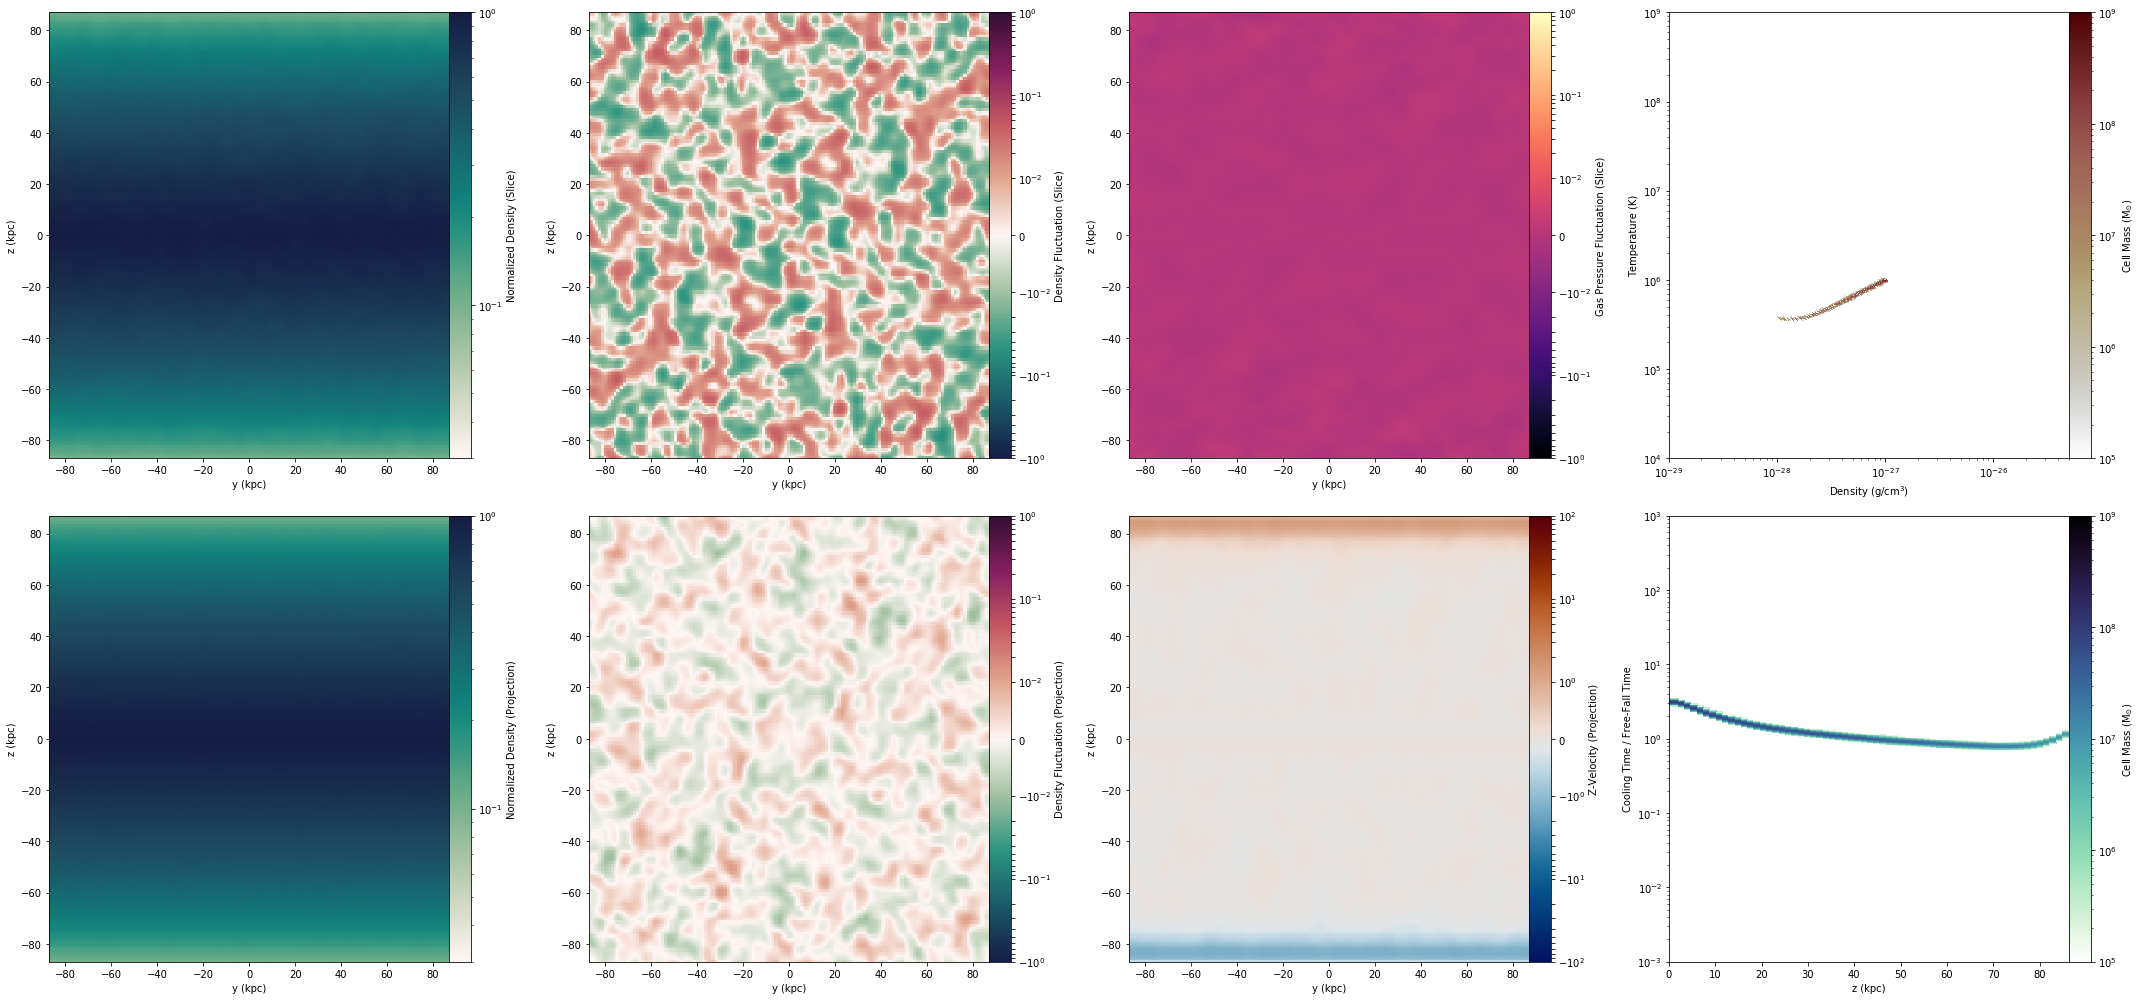

In [24]:
i = 1
folder = 'isocool2_tctf_1.0'
#folder = 'isocool_tctf_1.0_beta_10.0_cr_10.0'
ds = ytf.load('../../simulations/%s/DD%04d/DD%04d'%(folder, i, i))
fig, ax = pt.plot_density_slices(ds)

# next idea: try setting boundary to only quadratic extrapolation

yt : [INFO     ] 2019-11-05 13:00:34,575 Parameters: current_time              = 0.099999243011884
yt : [INFO     ] 2019-11-05 13:00:34,576 Parameters: domain_dimensions         = [128 128 128]
yt : [INFO     ] 2019-11-05 13:00:34,576 Parameters: domain_left_edge          = [-2. -2. -2.]
yt : [INFO     ] 2019-11-05 13:00:34,577 Parameters: domain_right_edge         = [2. 2. 2.]
yt : [INFO     ] 2019-11-05 13:00:34,578 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2019-11-05 13:00:34,617 Gathering a field list (this may take a moment.)
/mnt/ceph/users/ibutsky/thermal_instabilities/analysis/yt_functions.py:67: UserWarning: Because 'sampling_type' not specified, yt will assume a cell 'sampling_type'
  display_name = 'External Acceleration Z', units = 'cm/s**2')
/mnt/ceph/users/ibutsky/thermal_instabilities/analysis/yt_functions.py:70: UserWarning: Because 'sampling_type' not specified, yt will assume a cell 'sampling_type'
  display_name = 'Free Fall Time', units = 's')
/mn


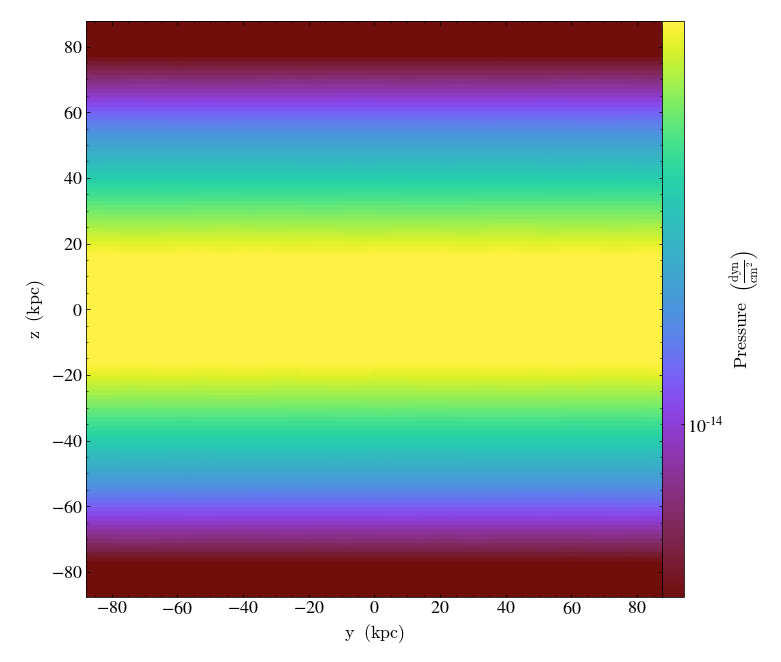

yt : [INFO     ] 2019-11-05 13:00:36,321 xlim = -2.000000 2.000000
yt : [INFO     ] 2019-11-05 13:00:36,322 ylim = -2.000000 2.000000
yt : [INFO     ] 2019-11-05 13:00:36,323 xlim = -2.000000 2.000000
yt : [INFO     ] 2019-11-05 13:00:36,324 ylim = -2.000000 2.000000
yt : [INFO     ] 2019-11-05 13:00:36,326 Making a fixed resolution buffer of (('gas', 'pressure')) 800 by 800



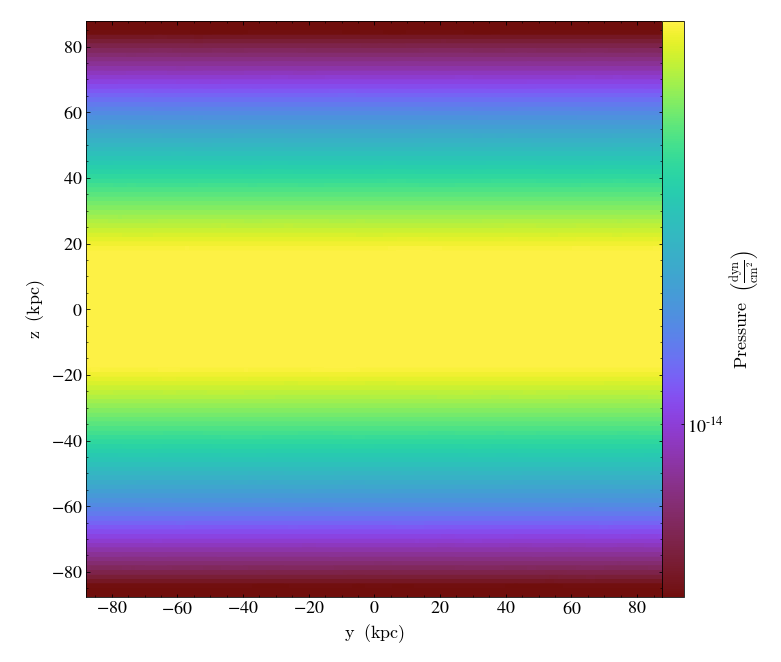

In [15]:
folder = 'isocool_tctf_1.0_beta_10.0'
ds2 = ytf.load('../../simulations/%s/DD%04d/DD%04d'%(folder, i, i))
s = yt.SlicePlot(ds, 'x', ('gas', 'pressure'))
s.set_zlim(('gas', 'pressure'), 5e-15, 5e-14)
s.show()
s = yt.SlicePlot(ds2, 'x', ('gas', 'pressure'))
s.set_zlim(('gas', 'pressure'), 5e-15, 5e-14)
s.show()

yt : [INFO     ] 2019-11-04 08:25:38,589 Parameters: current_time              = 0
yt : [INFO     ] 2019-11-04 08:25:38,590 Parameters: domain_dimensions         = [128 128 128]
yt : [INFO     ] 2019-11-04 08:25:38,591 Parameters: domain_left_edge          = [-2. -2. -2.]
yt : [INFO     ] 2019-11-04 08:25:38,592 Parameters: domain_right_edge         = [2. 2. 2.]
yt : [INFO     ] 2019-11-04 08:25:38,592 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2019-11-04 08:25:38,598 Gathering a field list (this may take a moment.)
/simons/scratch/ibutsky/thermal_instabilities/analysis/yt_functions.py:58: UserWarning: Because 'sampling_type' not specified, yt will assume a cell 'sampling_type'
  display_name = 'External Acceleration Z', units = 'cm/s**2')
/simons/scratch/ibutsky/thermal_instabilities/analysis/yt_functions.py:61: UserWarning: Because 'sampling_type' not specified, yt will assume a cell 'sampling_type'
  display_name = 'Free Fall Time', units = 's')
/simons/scratch/ibu

(1e-15, 1e-13)

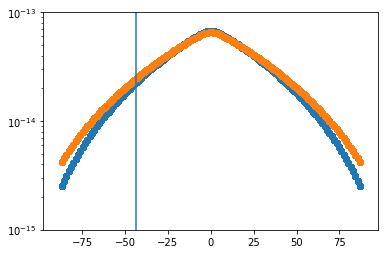

In [2]:
i = 0
ds1 = ytf.load('../../simulations/isocool_tctf_1.0/DD%04d/DD%04d'%(i, i))
ds2 = ytf.load('../../simulations/isocool_tctf_1.0_beta_10.0/DD%04d/DD%04d'%(i, i))
ad = ds1.all_data()
ad2 = ds2.all_data()
z = ad[('gas', 'z')].in_units('kpc')
z2 = ad2[('gas', 'z')].in_units('kpc')

pgas1 = ad[('gas', 'pressure')]
pgas2 = ad2[('gas', 'pressure')] + ad2[('gas', 'magnetic_pressure')]# + ad2[('gas', 'cr_pressure')]
plt.yscale('log')
plt.scatter(z, pgas1)
plt.scatter(z2, pgas2)
#plt.scatter(z, ptot2 / 2 )
plt.axvline(-43.8)
plt.ylim(1e-15, 1e-13)

In [3]:
i = 35
#ds = ytf.load('../../simulations/isocool_tctf_1.0_beta_10.0_cr_10.0/DD%04d/DD%04d'%(i, i))
ds = ytf.load('../../simulations/isocool_tctf_1.0_beta_3.0/DD%04d/DD%04d'%(i, i))

ad = ds.all_data()
min(ad[('gas', 'log_total_entropy')])

xfield = ('gas', 'z')
yfield = ('gas', 'log_total_entropy')
zfield = ('gas', 'cell_mass')
ph = yt.PhasePlot(ad, xfield, yfield, zfield, weight_field = None)
ph.set_unit(xfield, 'kpc')
ph.set_log(xfield, False)
#ph.set_ylim(22.4, 24.1)
ph.show()

yt : [ERROR    ] 2019-11-04 11:17:25,658 None of the arguments provided to load() is a valid file
yt : [ERROR    ] 2019-11-04 11:17:25,659 Please check that you have used a correct path


YTOutputNotIdentified: Supplied ('../../simulations/isocool_tctf_1.0_beta_3.0/DD0035/DD0035',) {}, but could not load!

In [2]:
# note: calculate effective entropy and see if it decreases with height

def _gasentropy(field, data):
    gamma = 5./3.
    mh     = YTQuantity(const.m_p.cgs.value, 'g')
    mu = 1.22
    
    p = data[('gas', 'pressure')]
    n = data[('gas', 'density')] / (mu * mh)
    return  p / np.power(n, gamma)

def _crentropy(field, data):
    crgamma = 4./3.
    mh     = YTQuantity(const.m_p.cgs.value, 'g')
    mu = 1.22
    
    pcr = data[('gas', 'cr_pressure')]
    n = data[('gas', 'density')] / (mu * mh)
    return  pcr / np.power(n, crgamma)
 
    
i = 30
folder = 'isothermal_tctf_1.0_beta_10.0_cr_3.0'
ds = ytf.load('../../simulations/%s/DD%04d/DD%04d'%(folder, i, i))
#ds.add_field(('gas', 'gas_entropy'), function = _gasentropy, units = 'cm**2 * keV', force_override = True)
#ds.add_field(('gas', 'cr_entropy'), function = _crentropy, units = 'cm**2 * keV', force_override = True)
ad = ds.all_data()
print(ad[('gas', 'gas_entropy')])
print(ad[('gas', 'cr_entropy')])


yt : [INFO     ] 2019-11-04 11:09:28,323 Parameters: current_time              = 2.9999990210575
yt : [INFO     ] 2019-11-04 11:09:28,324 Parameters: domain_dimensions         = [128 128 128]
yt : [INFO     ] 2019-11-04 11:09:28,326 Parameters: domain_left_edge          = [-3. -3. -3.]
yt : [INFO     ] 2019-11-04 11:09:28,327 Parameters: domain_right_edge         = [3. 3. 3.]
yt : [INFO     ] 2019-11-04 11:09:28,328 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2019-11-04 11:09:28,333 Gathering a field list (this may take a moment.)
/simons/scratch/ibutsky/thermal_instabilities/analysis/yt_functions.py:66: UserWarning: Because 'sampling_type' not specified, yt will assume a cell 'sampling_type'
  display_name = 'External Acceleration Z', units = 'cm/s**2')
/simons/scratch/ibutsky/thermal_instabilities/analysis/yt_functions.py:69: UserWarning: Because 'sampling_type' not specified, yt will assume a cell 'sampling_type'
  display_name = 'Free Fall Time', units = 's')
/simo

[96.6254488  95.19369973 93.792479   ... 88.66054597 89.59976932
 90.52982845] cm**2*keV
[1.32668515e-08 1.32315855e-08 1.31945631e-08 ... 1.32587964e-08
 1.33052818e-08 1.33507097e-08] cm**2*dyne


yt : [INFO     ] 2019-11-04 11:23:04,724 Parameters: current_time              = 4.9999990761866
yt : [INFO     ] 2019-11-04 11:23:04,725 Parameters: domain_dimensions         = [128 128 128]
yt : [INFO     ] 2019-11-04 11:23:04,726 Parameters: domain_left_edge          = [-2. -2. -2.]
yt : [INFO     ] 2019-11-04 11:23:04,727 Parameters: domain_right_edge         = [2. 2. 2.]
yt : [INFO     ] 2019-11-04 11:23:04,728 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2019-11-04 11:23:04,746 Gathering a field list (this may take a moment.)
yt : [WARNING  ] 2019-11-04 11:23:05,527 Field ('gas', 'log_total_entropy') already exists. To override use force_override=True.


(3, 6)

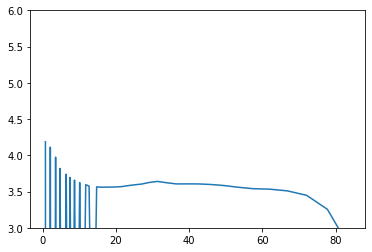

In [20]:

i = 50
folder = 'isocool_tctf_1.0_beta_10.0_cr_10.0'
ds = ytf.load('../../simulations/%s/DD%04d/DD%04d'%(folder, i, i))
ad = ds.all_data()
p = yt.ProfilePlot(ad, ('gas', 'z'), [('gas', 'log_total_entropy')])#, ('gas','cr_entropy')])#, ('gas', 'cr_eta')])
p.set_unit(('gas', 'z'), 'kpc')
p.set_log(('gas', 'z'), False)
profile = p.profiles[0]


#ge = profile[('gas', 'gas_entropy')]
#ce = profile[('gas', 'cr_entropy')]
#eta = profile[('gas', 'cr_eta')]
z = ad[('gas', 'z')]
y = profile[('gas', 'log_total_entropy')]
#y = np.log10(ge) + eta*np.log10(ce)

plt.plot(profile.x, y)
plt.ylim(3, 6)

#plt.yscale('log')



In [6]:
i = 0
ds1 = ytf.load('../../simulations/isothermal_tctf_1.0/DD%04d/DD%04d'%(i, i))
#ds2 = ytf.load('../../simulations/isothermal_tctf_1.0_beta_10.0/DD%04d/DD%04d'%(i, i))
ds2 = ytf.load('../../simulations/isothermal_tctf_1.0_beta_10.0_cr_3.0/DD%04d/DD%04d'%(i, i))
ad = ds1.all_data()
ad2 = ds2.all_data()

z = ad[('gas', 'z')].in_units('kpc')
ptot1 = ad[('gas', 'pressure')] + ad[('gas', 'magnetic_pressure')]
ptot2 = ad2[('gas', 'pressure')] + ad2[('gas', 'magnetic_pressure')] + ad2[('gas', 'cr_pressure')]

print("ptot1 / ptot2", ptot1/ ptot2)

print("pgas1 / pgas2", ad[('gas', 'pressure')] / ad2[('gas', 'pressure')])

print(ad2[('gas', 'cr_eta')], ad2[('gas', 'plasma_beta')])
print(ad2[('gas', 'pressure')] / ad2[('gas', 'magnetic_pressure')])
#print(ad[field] / ad2[field])

#ad2[('gas', 'cr_eta')]


yt : [INFO     ] 2019-10-29 07:17:57,835 Parameters: current_time              = 0
yt : [INFO     ] 2019-10-29 07:17:57,836 Parameters: domain_dimensions         = [128 128 128]
yt : [INFO     ] 2019-10-29 07:17:57,837 Parameters: domain_left_edge          = [-3. -3. -3.]
yt : [INFO     ] 2019-10-29 07:17:57,839 Parameters: domain_right_edge         = [3. 3. 3.]
yt : [INFO     ] 2019-10-29 07:17:57,840 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2019-10-29 07:17:58,088 Gathering a field list (this may take a moment.)
yt : [INFO     ] 2019-10-29 07:17:59,015 Parameters: current_time              = 0
yt : [INFO     ] 2019-10-29 07:17:59,016 Parameters: domain_dimensions         = [128 128 128]
yt : [INFO     ] 2019-10-29 07:17:59,017 Parameters: domain_left_edge          = [-3. -3. -3.]
yt : [INFO     ] 2019-10-29 07:17:59,018 Parameters: domain_right_edge         = [3. 3. 3.]
yt : [INFO     ] 2019-10-29 07:17:59,019 Parameters: cosmological_simulation   = 0.0
yt : [INFO

ptot1 / ptot2 [0.22493004 0.23304024 0.2414427  ... 0.2414427  0.23304024 0.22493004] dimensionless
pgas1 / pgas2 [0.92220966 0.95546136 0.98991134 ... 0.98991134 0.95546136 0.92220966] dimensionless
[2.999985 2.999985 2.999985 ... 2.999985 2.999985 2.999985] dimensionless [10.00005 10.00005 10.00005 ... 10.00005 10.00005 10.00005] dimensionless
[10.00005 10.00005 10.00005 ... 10.00005 10.00005 10.00005] dimensionless


yt : [INFO     ] 2019-11-01 09:52:49,040 Parameters: current_time              = 0
yt : [INFO     ] 2019-11-01 09:52:49,040 Parameters: domain_dimensions         = [128 128 128]
yt : [INFO     ] 2019-11-01 09:52:49,041 Parameters: domain_left_edge          = [-2. -2. -2.]
yt : [INFO     ] 2019-11-01 09:52:49,042 Parameters: domain_right_edge         = [2. 2. 2.]
yt : [INFO     ] 2019-11-01 09:52:49,043 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2019-11-01 09:52:49,047 Gathering a field list (this may take a moment.)


0.7121507808801493 kpc 737400801.9690477 yr
0.7681462026905994 kpc 0.0 yr
0.8285444663540846 kpc 0.0 yr
0.8936917611795883 kpc 0.0 yr
0.9639614968582149 kpc 0.0 yr
1.0397564437638385 kpc 0.0 yr
1.121511041542604 kpc 0.0 yr
1.2096938892235993 kpc 0.0 yr
1.3048104311234527 kpc 0.0 yr
1.4074058539398604 kpc 0.0 yr
1.518068211639533 kpc 0.0 yr
1.6374317960517195 kpc 0.0 yr
1.7661807724867966 kpc 0.0 yr
1.9050531012184697 kpc 0.0 yr
2.0548447673066494 kpc 737220752.7735493 yr
2.216414343005391 kpc 0.0 yr
2.3906879089065978 kpc 0.0 yr
2.5786643620264202 kpc 0.0 yr
2.781421141259029 kpc 0.0 yr
3.000120403014828 kpc 0.0 yr
3.2360156824405304 kpc 0.0 yr
3.490459078401626 kpc 737081458.8709636 yr
3.764909003410006 kpc 0.0 yr
4.060938542917576 kpc 0.0 yr
4.3802444718894575 kpc 0.0 yr
4.724656980337754 kpc 737625796.7091758 yr
5.096150163560461 kpc 0.0 yr
5.496853337213219 kpc 0.0 yr
5.929063242069363 kpc 0.0 yr
6.395257208423219 kpc 738712299.3983197 yr
6.898107355592054 kpc 0.0 yr
7.440495907905

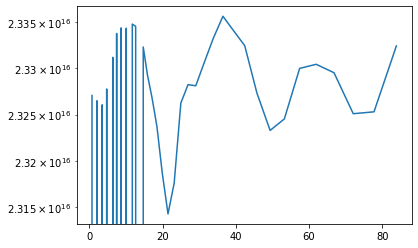

In [32]:
ds = ytf.load('../../simulations/isocool_tctf_1.0/DD0000/DD0000')
ad = ds.all_data()
field = ('gas', 'cooling_time')
p = yt.ProfilePlot(ad, ('gas', 'z'), field)
p.set_unit(('gas', 'z'), 'kpc')
p.set_log(('gas', 'z'), False)
#p.show()

profile = p.profiles[0]
pz = profile.x
py = profile[field]

plt.semilogy(pz, py)#.in_units('yr'))
#plt.scatter(43.85, 9.86e-29)
for z, y in zip(pz, py):
    print(z, y.in_units('yr'))


yt : [INFO     ] 2019-11-04 11:17:35,016 Parameters: current_time              = 3.9999990458705
yt : [INFO     ] 2019-11-04 11:17:35,016 Parameters: domain_dimensions         = [128 128 128]
yt : [INFO     ] 2019-11-04 11:17:35,017 Parameters: domain_left_edge          = [-2. -2. -2.]
yt : [INFO     ] 2019-11-04 11:17:35,018 Parameters: domain_right_edge         = [2. 2. 2.]
yt : [INFO     ] 2019-11-04 11:17:35,019 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2019-11-04 11:17:35,024 Gathering a field list (this may take a moment.)
/simons/scratch/ibutsky/thermal_instabilities/analysis/yt_functions.py:83: UserWarning: Because 'sampling_type' not specified, yt will assume a cell 'sampling_type'
  display_name = 'Cosmic Ray Energy', units = 'erg/g')
/simons/scratch/ibutsky/thermal_instabilities/analysis/yt_functions.py:85: UserWarning: Because 'sampling_type' not specified, yt will assume a cell 'sampling_type'
  display_name = 'Cosmic Ray Pressure', units = 'dyne/cm**2')


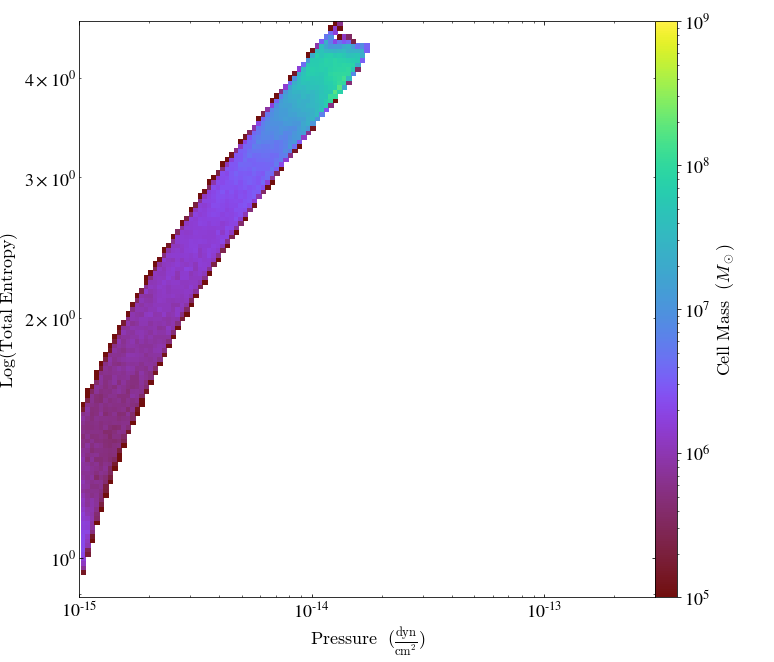

In [4]:
folder = 'isothermal_tctf_1.0'
folder = 'isocool_tctf_1.0_beta_10.0_cr_3.0'
#folder = 'isentropic_tctf_1.0'
i = 40
ds = ytf.load('../../simulations/%s/DD%04d/DD%04d'%(folder, i, i))
ad = ds.all_data()

xfield = ('gas', 'pressure')
yfield = ('gas', 'log_total_entropy')
zfield = ('gas', 'cell_mass')
ph = yt.PhasePlot(ad, xfield, yfield, zfield, weight_field = None)
ph.set_unit(zfield, 'Msun')
ph.set_zlim(zfield, 1e5, 1e9)

ph.set_xlim(1e-15, 3e-13)
#ph.set_ylim(3e-2, 1e3)
ph.show()

yt : [INFO     ] 2019-11-04 11:19:20,448 Parameters: current_time              = 0.99999906977976
yt : [INFO     ] 2019-11-04 11:19:20,449 Parameters: domain_dimensions         = [128 128 128]
yt : [INFO     ] 2019-11-04 11:19:20,450 Parameters: domain_left_edge          = [-2. -2. -2.]
yt : [INFO     ] 2019-11-04 11:19:20,451 Parameters: domain_right_edge         = [2. 2. 2.]
yt : [INFO     ] 2019-11-04 11:19:20,452 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2019-11-04 11:19:20,466 Gathering a field list (this may take a moment.)
/simons/scratch/ibutsky/thermal_instabilities/analysis/yt_functions.py:66: UserWarning: Because 'sampling_type' not specified, yt will assume a cell 'sampling_type'
  display_name = 'External Acceleration Z', units = 'cm/s**2')
/simons/scratch/ibutsky/thermal_instabilities/analysis/yt_functions.py:69: UserWarning: Because 'sampling_type' not specified, yt will assume a cell 'sampling_type'
  display_name = 'Free Fall Time', units = 's')
/sim


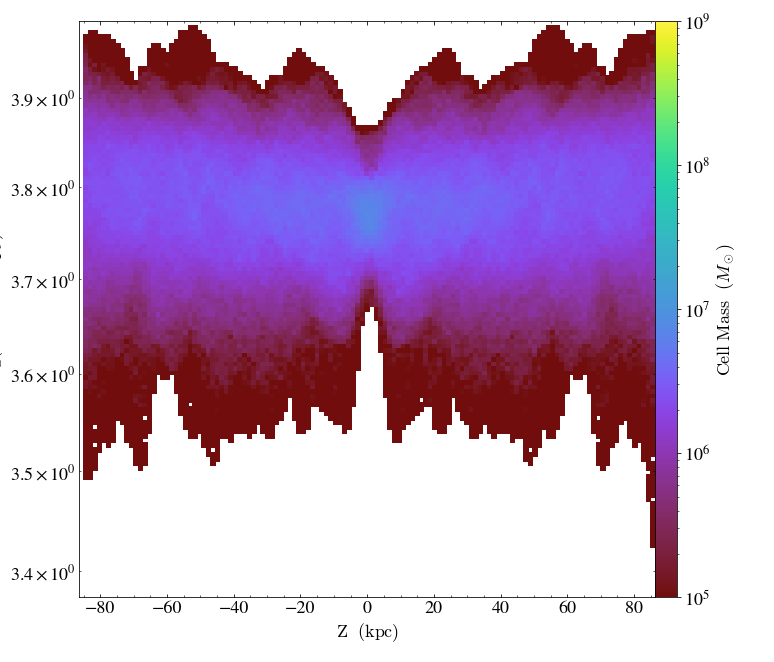

In [8]:
folder = 'isothermal_tctf_1.0'
folder = 'isocool_tctf_1.0_beta_10.0_cr_3.0'
#folder = 'isentropic_tctf_1.0'
i = 10
ds = ytf.load('../../simulations/%s/DD%04d/DD%04d'%(folder, i, i))
ad = ds.all_data()

xfield = ('gas', 'z')
yfield = ('gas', 'log_total_entropy')
zfield = ('gas', 'cell_mass')
ph = yt.PhasePlot(ad, xfield, yfield, zfield, weight_field = None)
ph.set_unit(zfield, 'Msun')
ph.set_zlim(zfield, 1e5, 1e9)
ph.set_unit(xfield, 'kpc')
ph.set_log(xfield, False)

#ph.set_xlim(1e-15, 3e-13)
#ph.set_ylim(3e-2, 1e3)
ph.show()

In [15]:
low = ds.domain_left_edge
dims = [128, 128, 128]
cube = ds.covering_grid(0, left_edge = ds.domain_left_edge, dims = dims, \
                        fields = [('gas', 'density'), ('gas', 'thermal_energy')])
                        

In [102]:
rho = cube[('gas', 'density')]

In [104]:
nx, ny, nz = rho.shape

In [105]:
nx

128